In [3]:
import json
import torch
import itertools
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_path = 'data/nsynth-train'

In [5]:
annots = json.load(open(f'{data_path}/examples.json'))

# EDA

## Annotation files

Loading annotation file

In [6]:
data = pd.DataFrame.from_dict(annots, orient='index')
data

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
guitar_acoustic_001-082-050,16629,16000,82,0,guitar,guitar_acoustic_001,guitar_acoustic_001-082-050,[percussive],acoustic,50,3,39,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
bass_synthetic_120-108-050,168243,16000,108,2,bass,bass_synthetic_120,bass_synthetic_120-108-050,[percussive],synthetic,50,0,881,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
organ_electronic_120-050-127,88495,16000,50,1,organ,organ_electronic_120,organ_electronic_120-050-127,[],electronic,127,6,979,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
guitar_electronic_021-026-025,146382,16000,26,1,guitar,guitar_electronic_021,guitar_electronic_021-026-025,"[fast_decay, percussive]",electronic,25,3,346,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
organ_electronic_011-079-075,244275,16000,79,1,organ,organ_electronic_011,organ_electronic_011-079-075,[bright],electronic,75,6,188,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
organ_electronic_083-039-100,190815,16000,39,1,organ,organ_electronic_083,organ_electronic_083-039-100,[dark],electronic,100,6,808,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_electronic_024-053-025,81228,16000,53,1,bass,bass_electronic_024,bass_electronic_024-053-025,[distortion],electronic,25,0,847,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
string_acoustic_082-058-100,20732,16000,58,0,string,string_acoustic_082,string_acoustic_082-058-100,[reverb],acoustic,100,8,699,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
reed_acoustic_020-056-100,28856,16000,56,0,reed,reed_acoustic_020,reed_acoustic_020-056-100,[],acoustic,100,7,200,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [7]:
# setting plt params
plt.rcParams['font.size'] = 20
rect_ratio = (20, 15)
sq_ratio = (15, 15)

### Pitch
Might be necessary to exclude low and high pitch (< 20, > 110) samples to compensate imbalance, as well as duplicating some of the others

Text(0.5, 1.0, 'Pitch feature distribution')

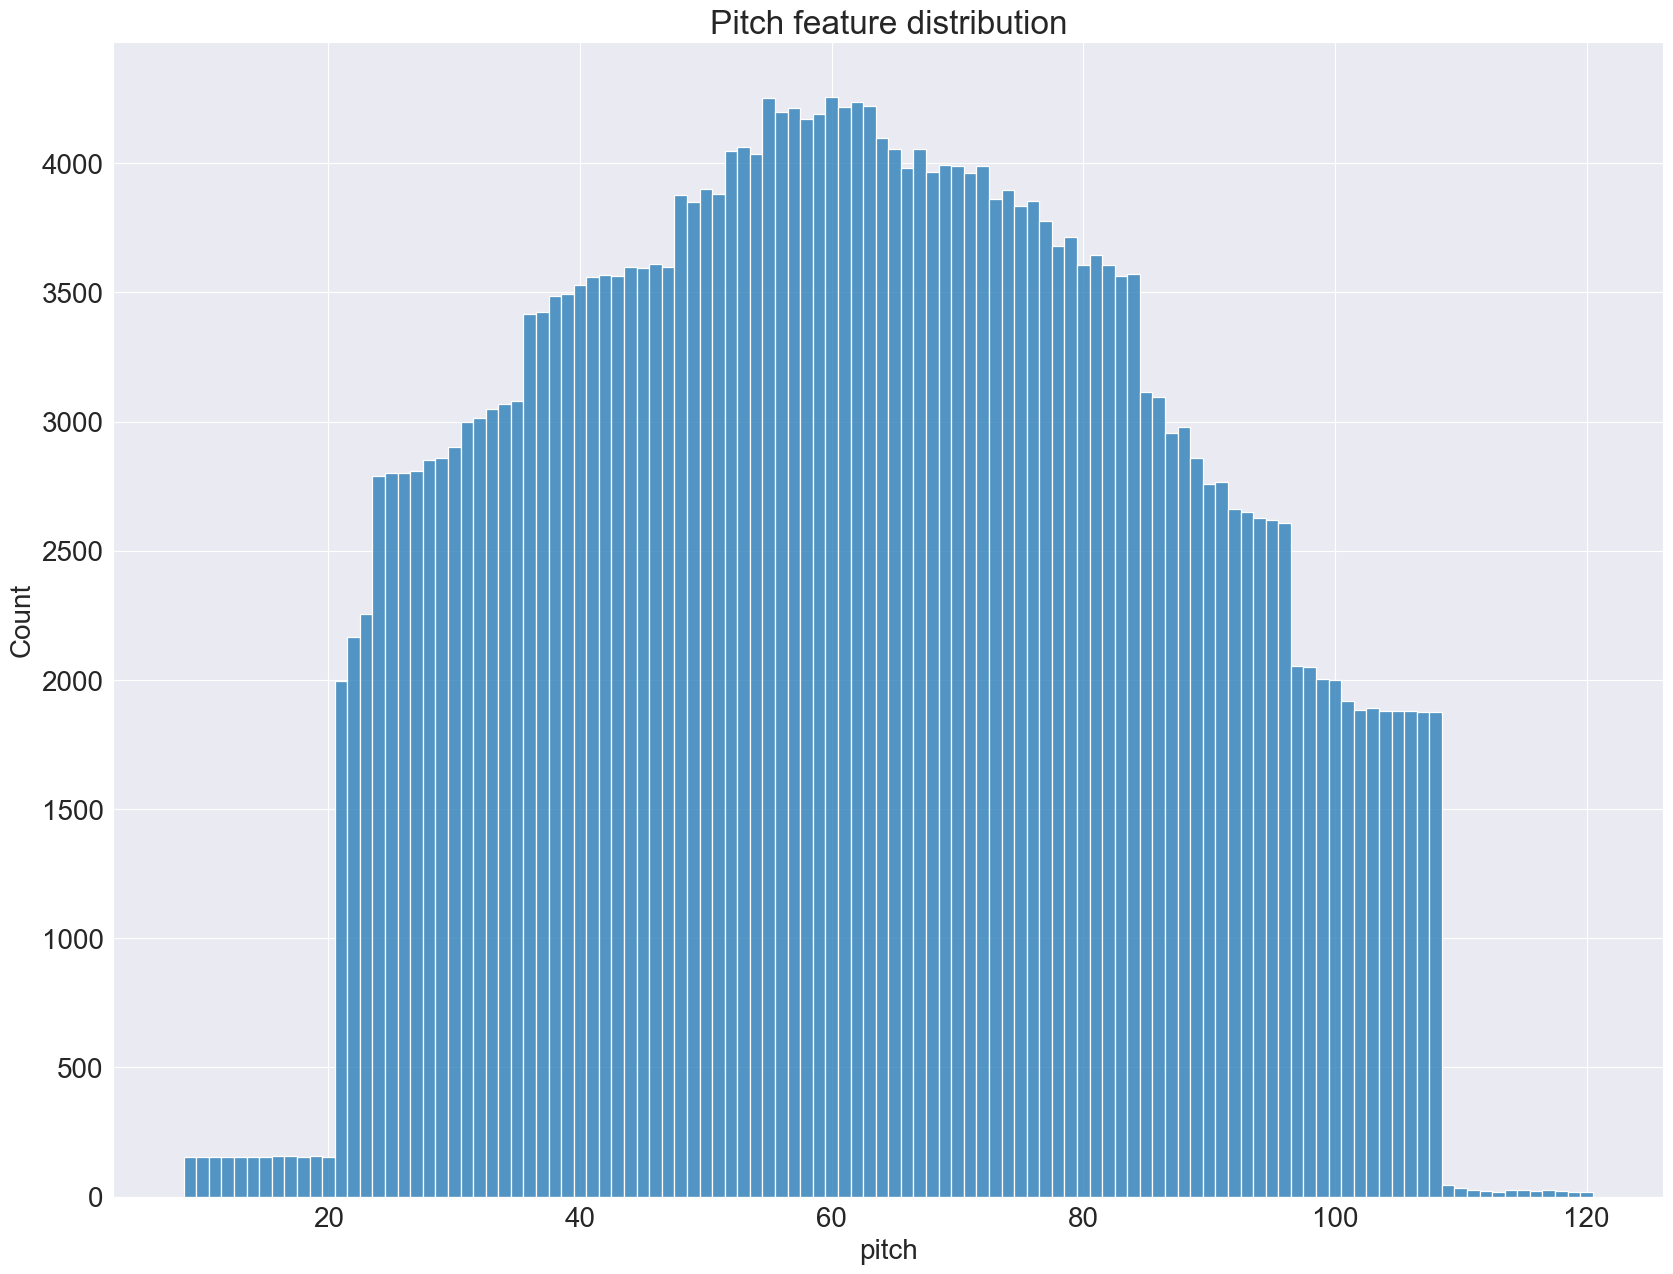

In [8]:
fig, ax = plt.subplots(1, 1, figsize=rect_ratio)
#sns.histplot(data['pitch'], bins=range(127), ax=ax) #, kde='true')
sns.histplot(data['pitch'], discrete=True, ax=ax) #, kde='true')
ax.set_title('Pitch feature distribution')

### Velocity
Balanced


Text(0.5, 1.0, 'Velocity feature distribution')

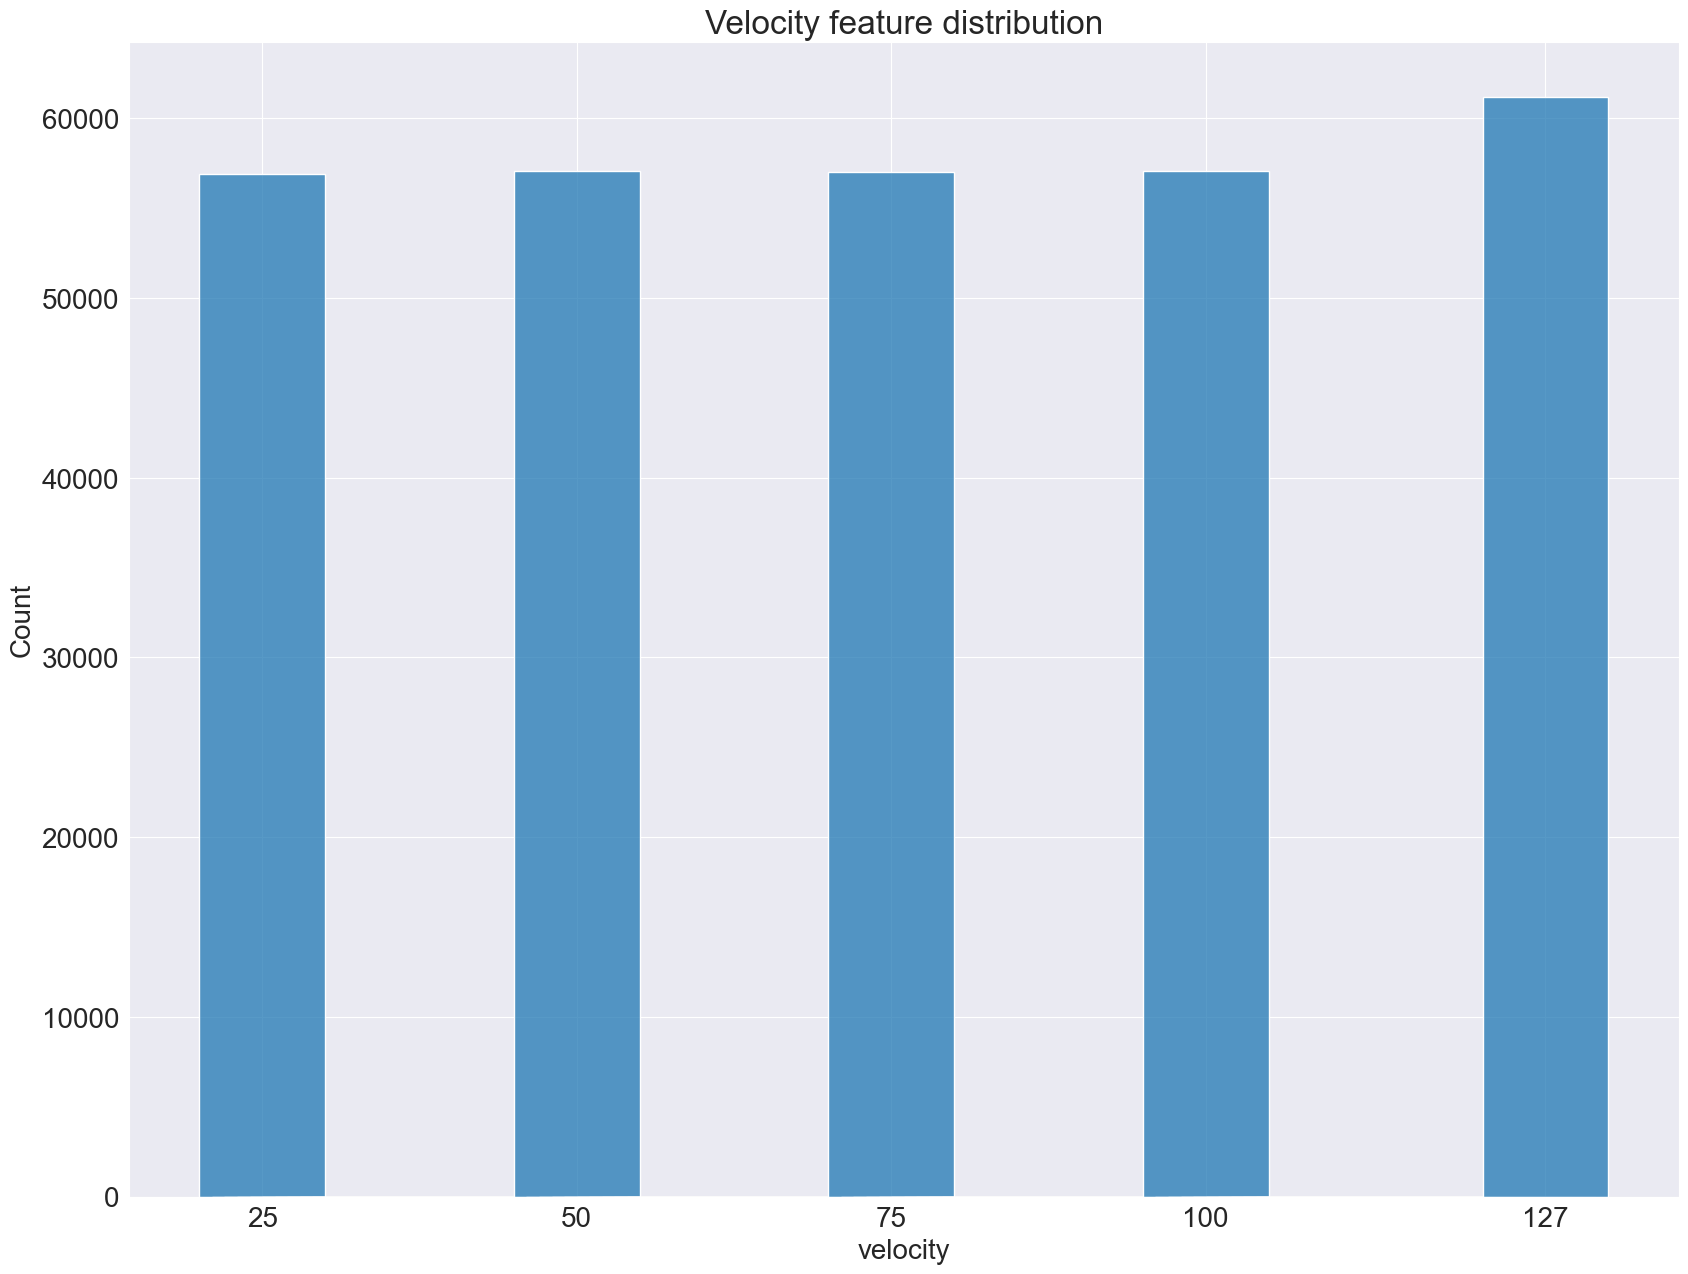

In [9]:
fig, ax = plt.subplots(1, 1, figsize=rect_ratio)
sns.histplot(data['velocity'], ax=ax, discrete=True, shrink=10)
ax.set_xticks(data['velocity'].unique())
ax.set_title('Velocity feature distribution')

### Sample rate (to be discarded)

In [10]:
data['sample_rate'].nunique()

1

### Instrument family

Strong class imbalance. Possible workarounds:

- Cutting down the dataset to 5000 samples per instrument
- Discarding classes that represent < 10% of dataset
- Augmenting dataset (duplicating samples from underrepresented classes with additonal random noise)

Text(0.5, 1.0, 'Data by instrument family')

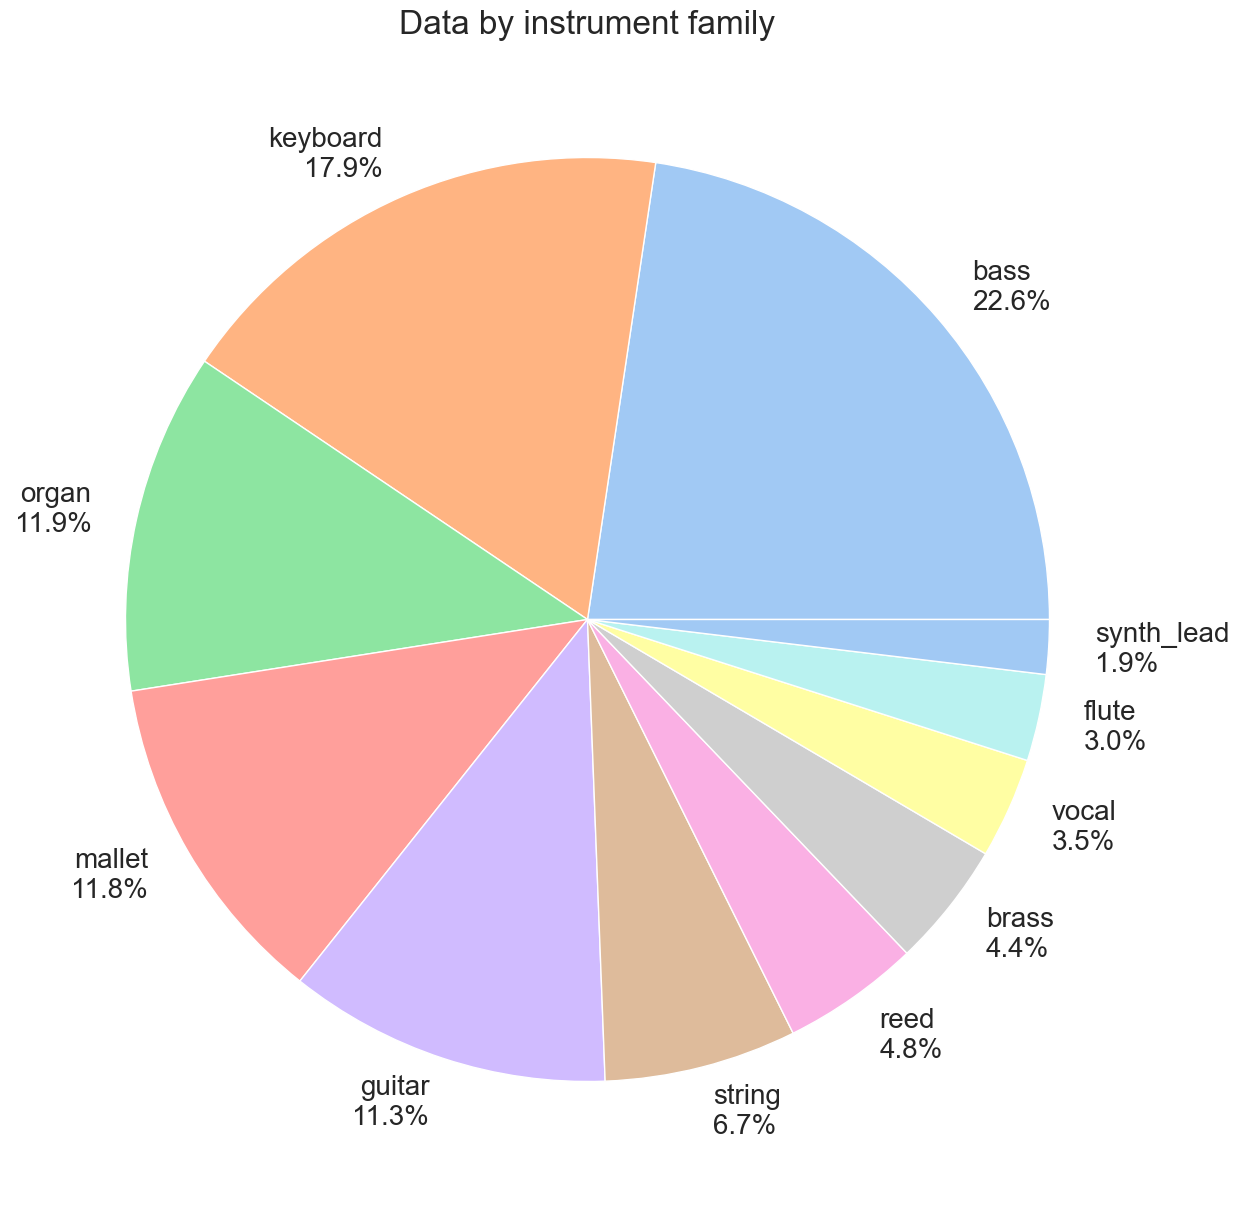

In [11]:
%%capture --no-display

counts = data['instrument_family_str'].value_counts()
perc = round(100 * counts / counts.sum(), 1)
labels = [f'{instr}\n{p}%' for instr, p in zip(counts.index, perc)]
          

fig, ax = plt.subplots(1, 1, figsize=sq_ratio)
ax.pie(counts, labels = labels, colors=sns.color_palette('pastel'))
ax.set_title('Data by instrument family')

In [12]:
counts

instrument_family_str
bass          65474
keyboard      51821
organ         34477
mallet        34201
guitar        32690
string        19474
reed          13911
brass         12675
vocal         10208
flute          8773
synth_lead     5501
Name: count, dtype: int64

### Instrument source
Reasonably balanced

Text(0.5, 1.0, 'Data by instrument source')

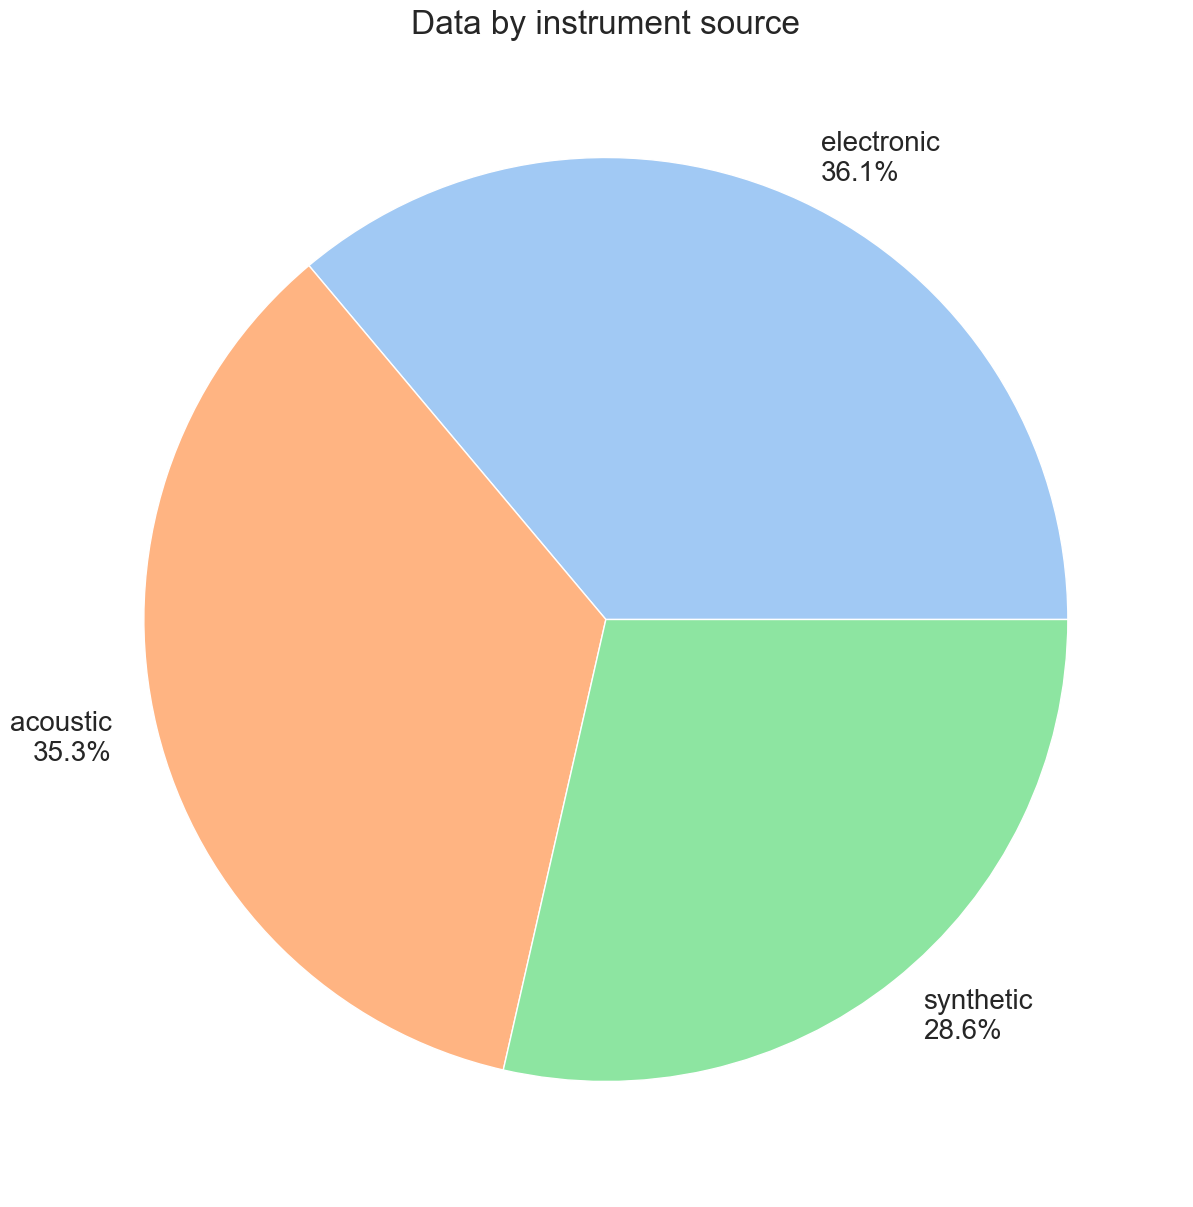

In [13]:
%%capture --no-display

counts = data['instrument_source_str'].value_counts()
perc = round(100 * counts / counts.sum(), 1)
labels = [f'{instr}\n{p}%' for instr, p in zip(counts.index, perc)]
          

fig, ax = plt.subplots(1, 1, figsize=sq_ratio)
ax.pie(counts, labels = labels, colors=sns.color_palette('pastel'))
ax.set_title('Data by instrument source')

### Qualities

10 different qualities - datapoints can also have more than one or none

Text(0.5, 1.0, 'Data qualities')

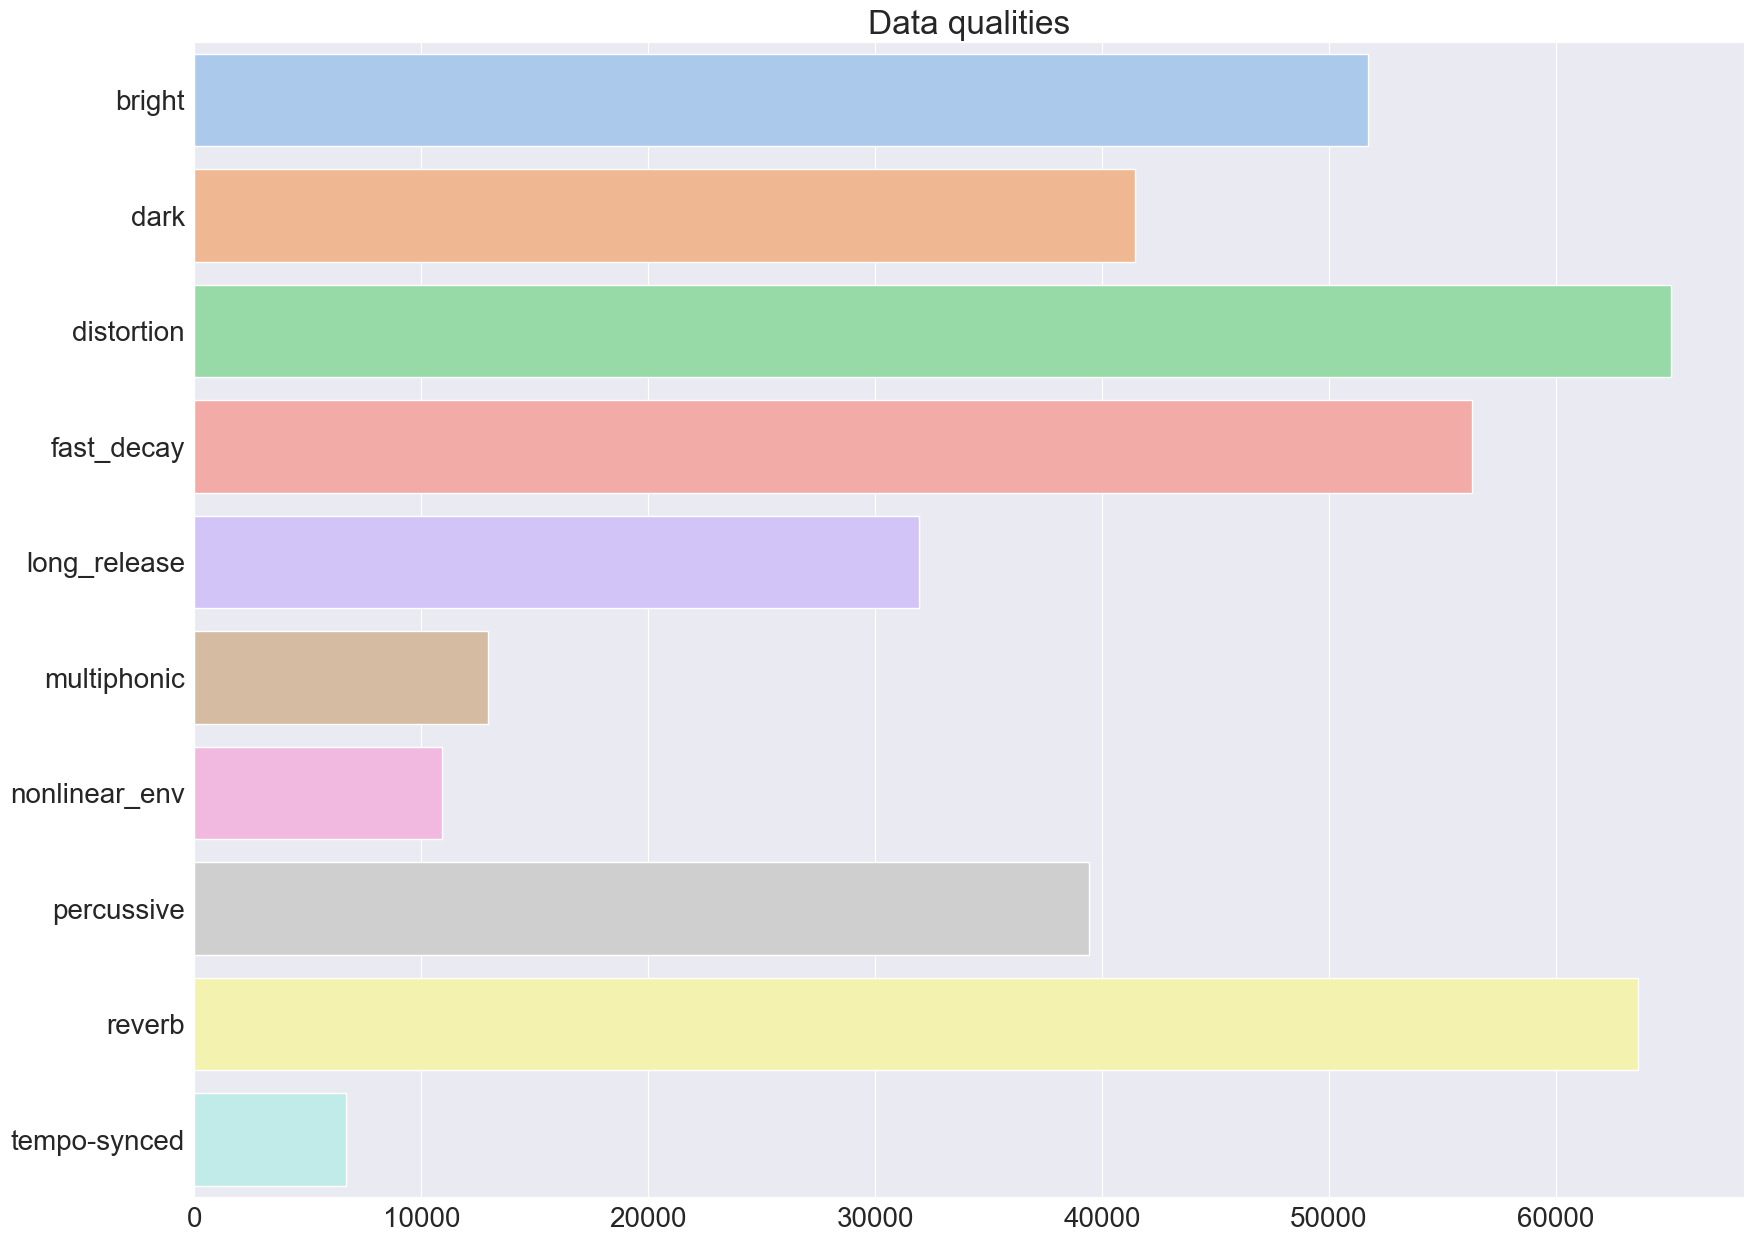

In [14]:
labels = sorted(set(itertools.chain(*data['qualities_str'])))
qual = sum(data['qualities'].apply(np.asarray))

fig, ax = plt.subplots(1, 1, figsize=rect_ratio)
sns.barplot(x=qual, y=labels, palette='pastel')
ax.set_title('Data qualities')

## Audio / Mel specs

In [15]:
from NSynthDataset import NSynthDataset

In [16]:
audios = NSynthDataset()
mels = NSynthDataset(mel=True)

In [50]:
data['instrument_str'].apply(lambda x: x.rsplit('_', 1)[0])

KeyError: 0

In [82]:
for x in data:
    x.apply(lambda x: data.loc[x, 'instrument_str'].rsplit('_', 1)[0])

AttributeError: 'str' object has no attribute 'apply'

Here we select one of each instrument and source

In [79]:
instr_groups = data.groupby(lambda x: data.loc[x, 'instrument_str'].rsplit('_', 1)[0])
samples = [gdata.sample(1) for _, gdata in instr_groups]
samples

[                             note  sample_rate  pitch  instrument_source  \
 bass_acoustic_000-040-075  232987        16000     40                  0   
 
                           instrument_family_str     instrument_str  \
 bass_acoustic_000-040-075                  bass  bass_acoustic_000   
 
                                             note_str qualities_str  \
 bass_acoustic_000-040-075  bass_acoustic_000-040-075        [dark]   
 
                           instrument_source_str  velocity  instrument_family  \
 bass_acoustic_000-040-075              acoustic        75                  0   
 
                            instrument                       qualities  
 bass_acoustic_000-040-075          70  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  ,
                                note  sample_rate  pitch  instrument_source  \
 bass_electronic_003-024-127  101135        16000     24                  1   
 
                             instrument_family_str       instrument_str  \
 bass_elec

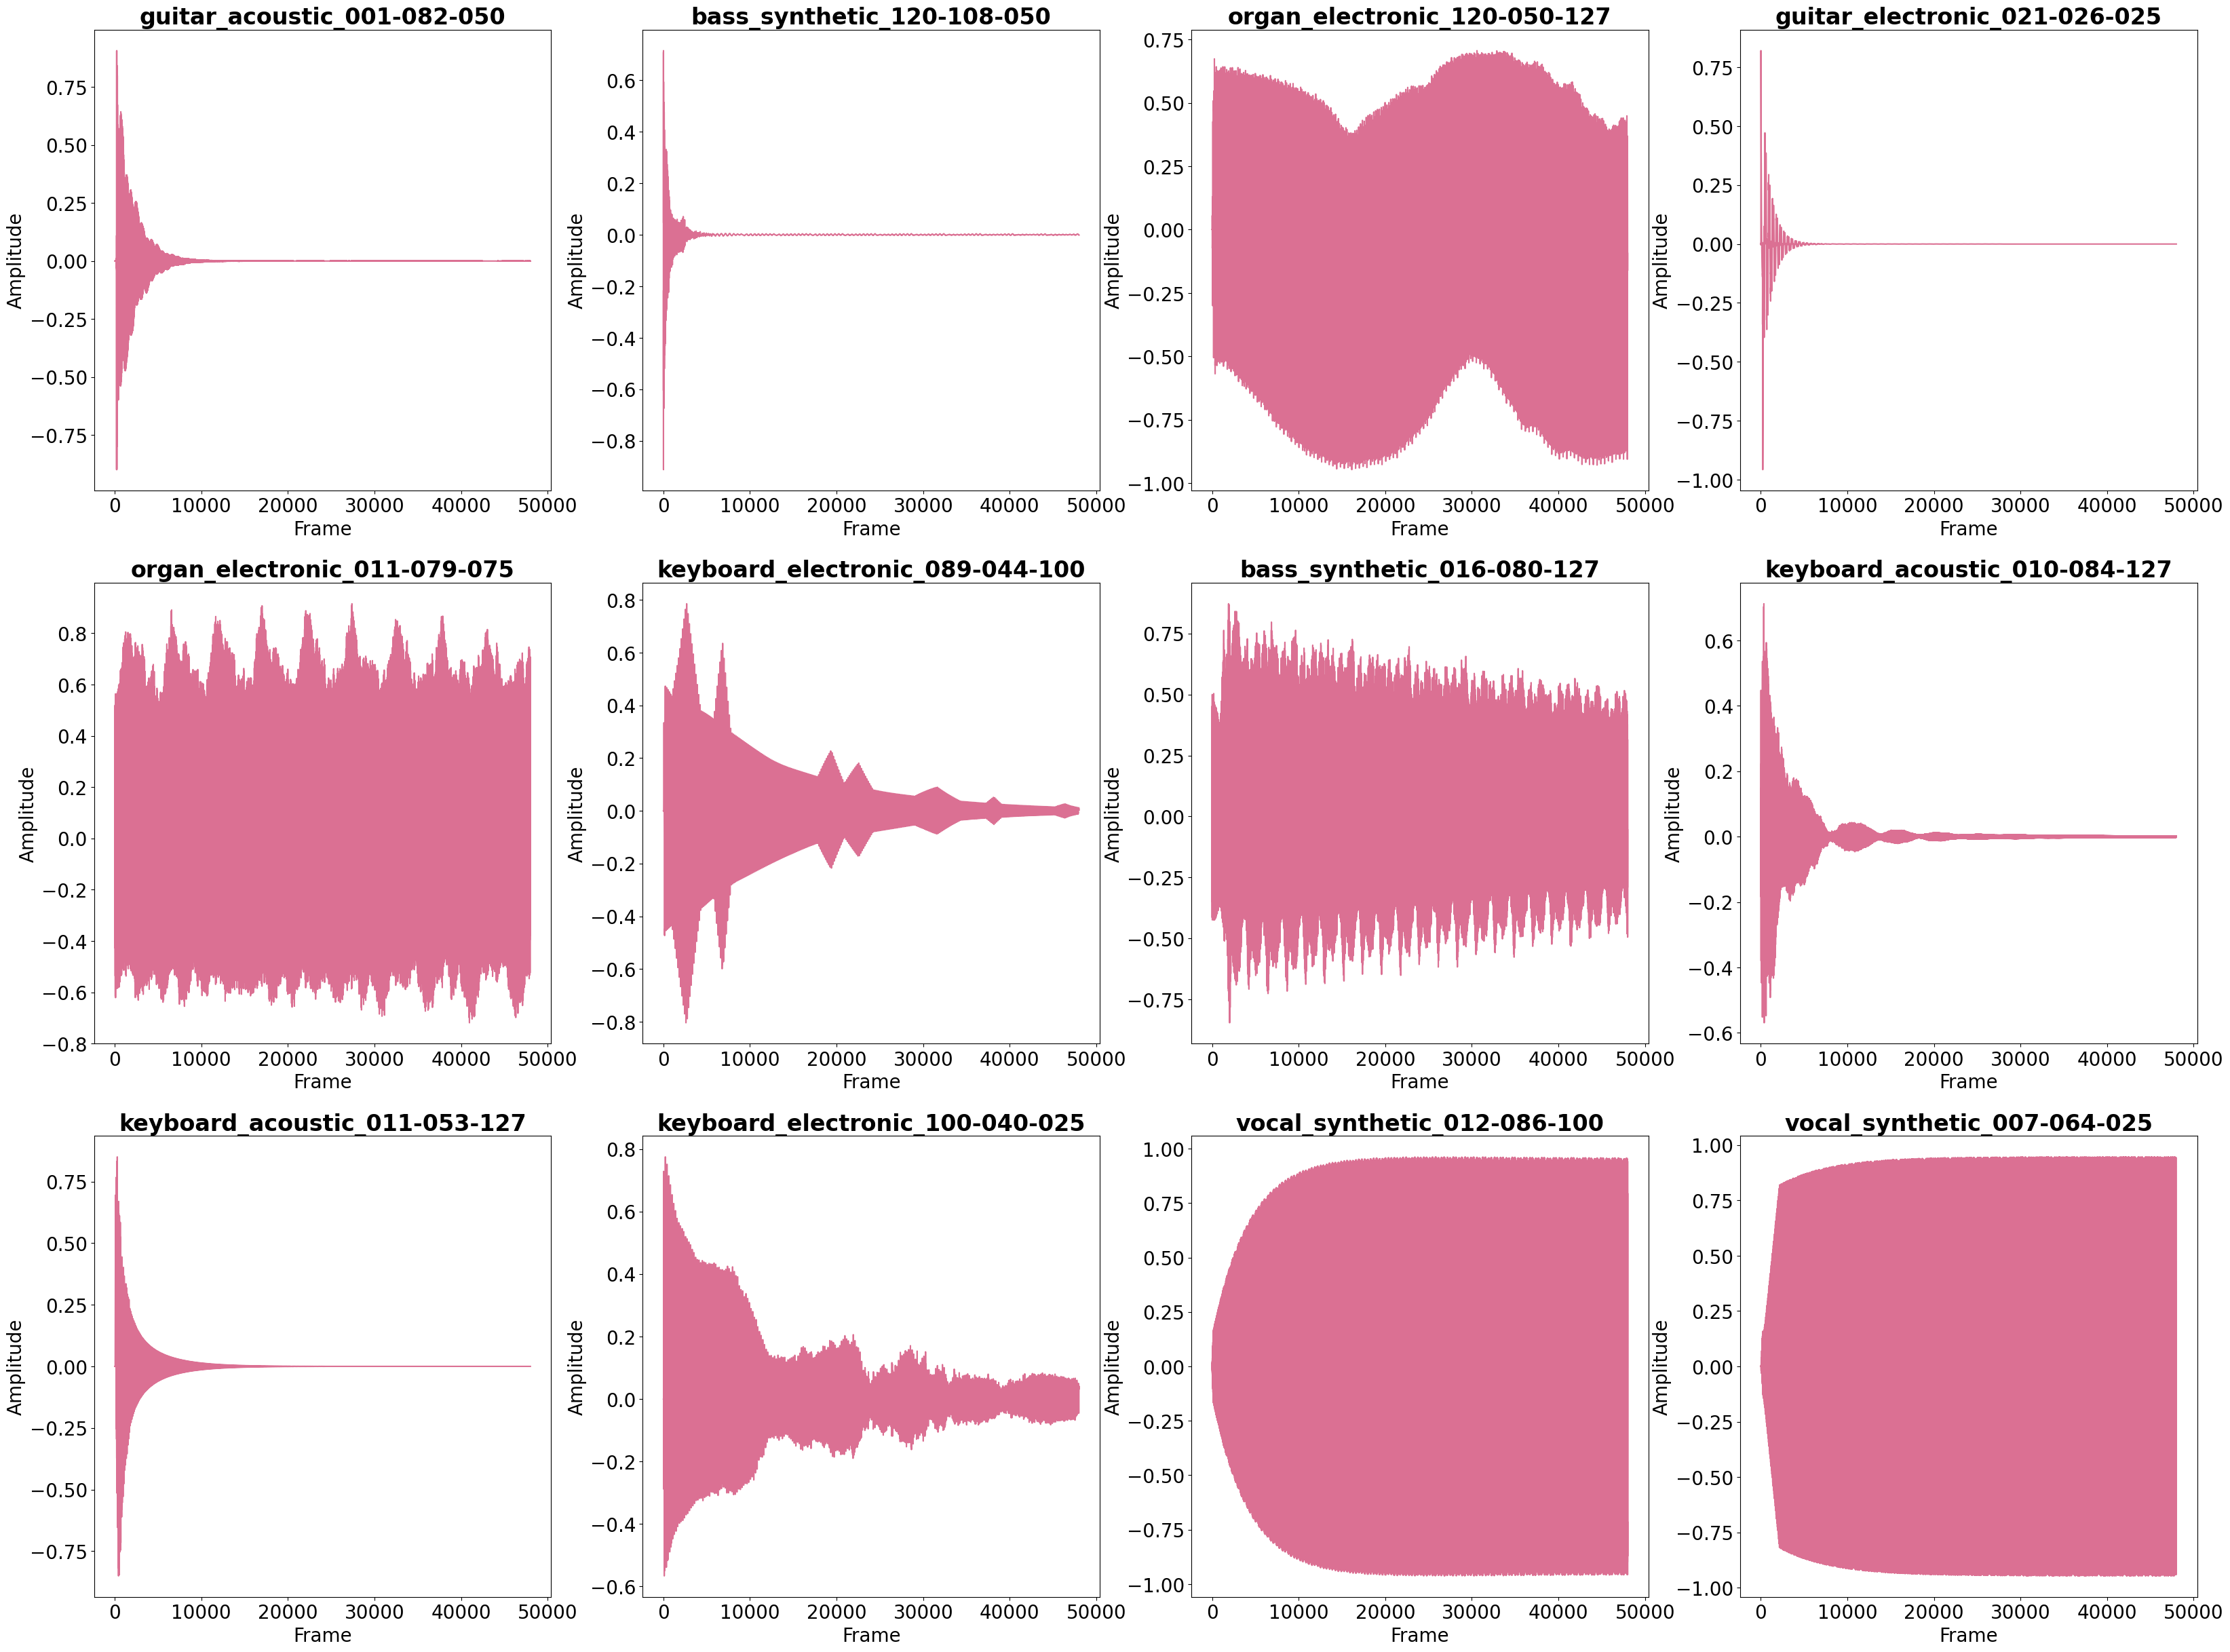

In [37]:
fig, axs = plt.subplots(3, 4, figsize=(40, 30))
for i in range(12):
    ax = axs.flatten()[i]
    a, l = audios.__getitem__(i)
    sns.lineplot(a, ax=ax, c='palevioletred')
    ax.set_title(audios.fnames[i], fontdict={'fontsize':'large', 'weight':'bold'})
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Frame')

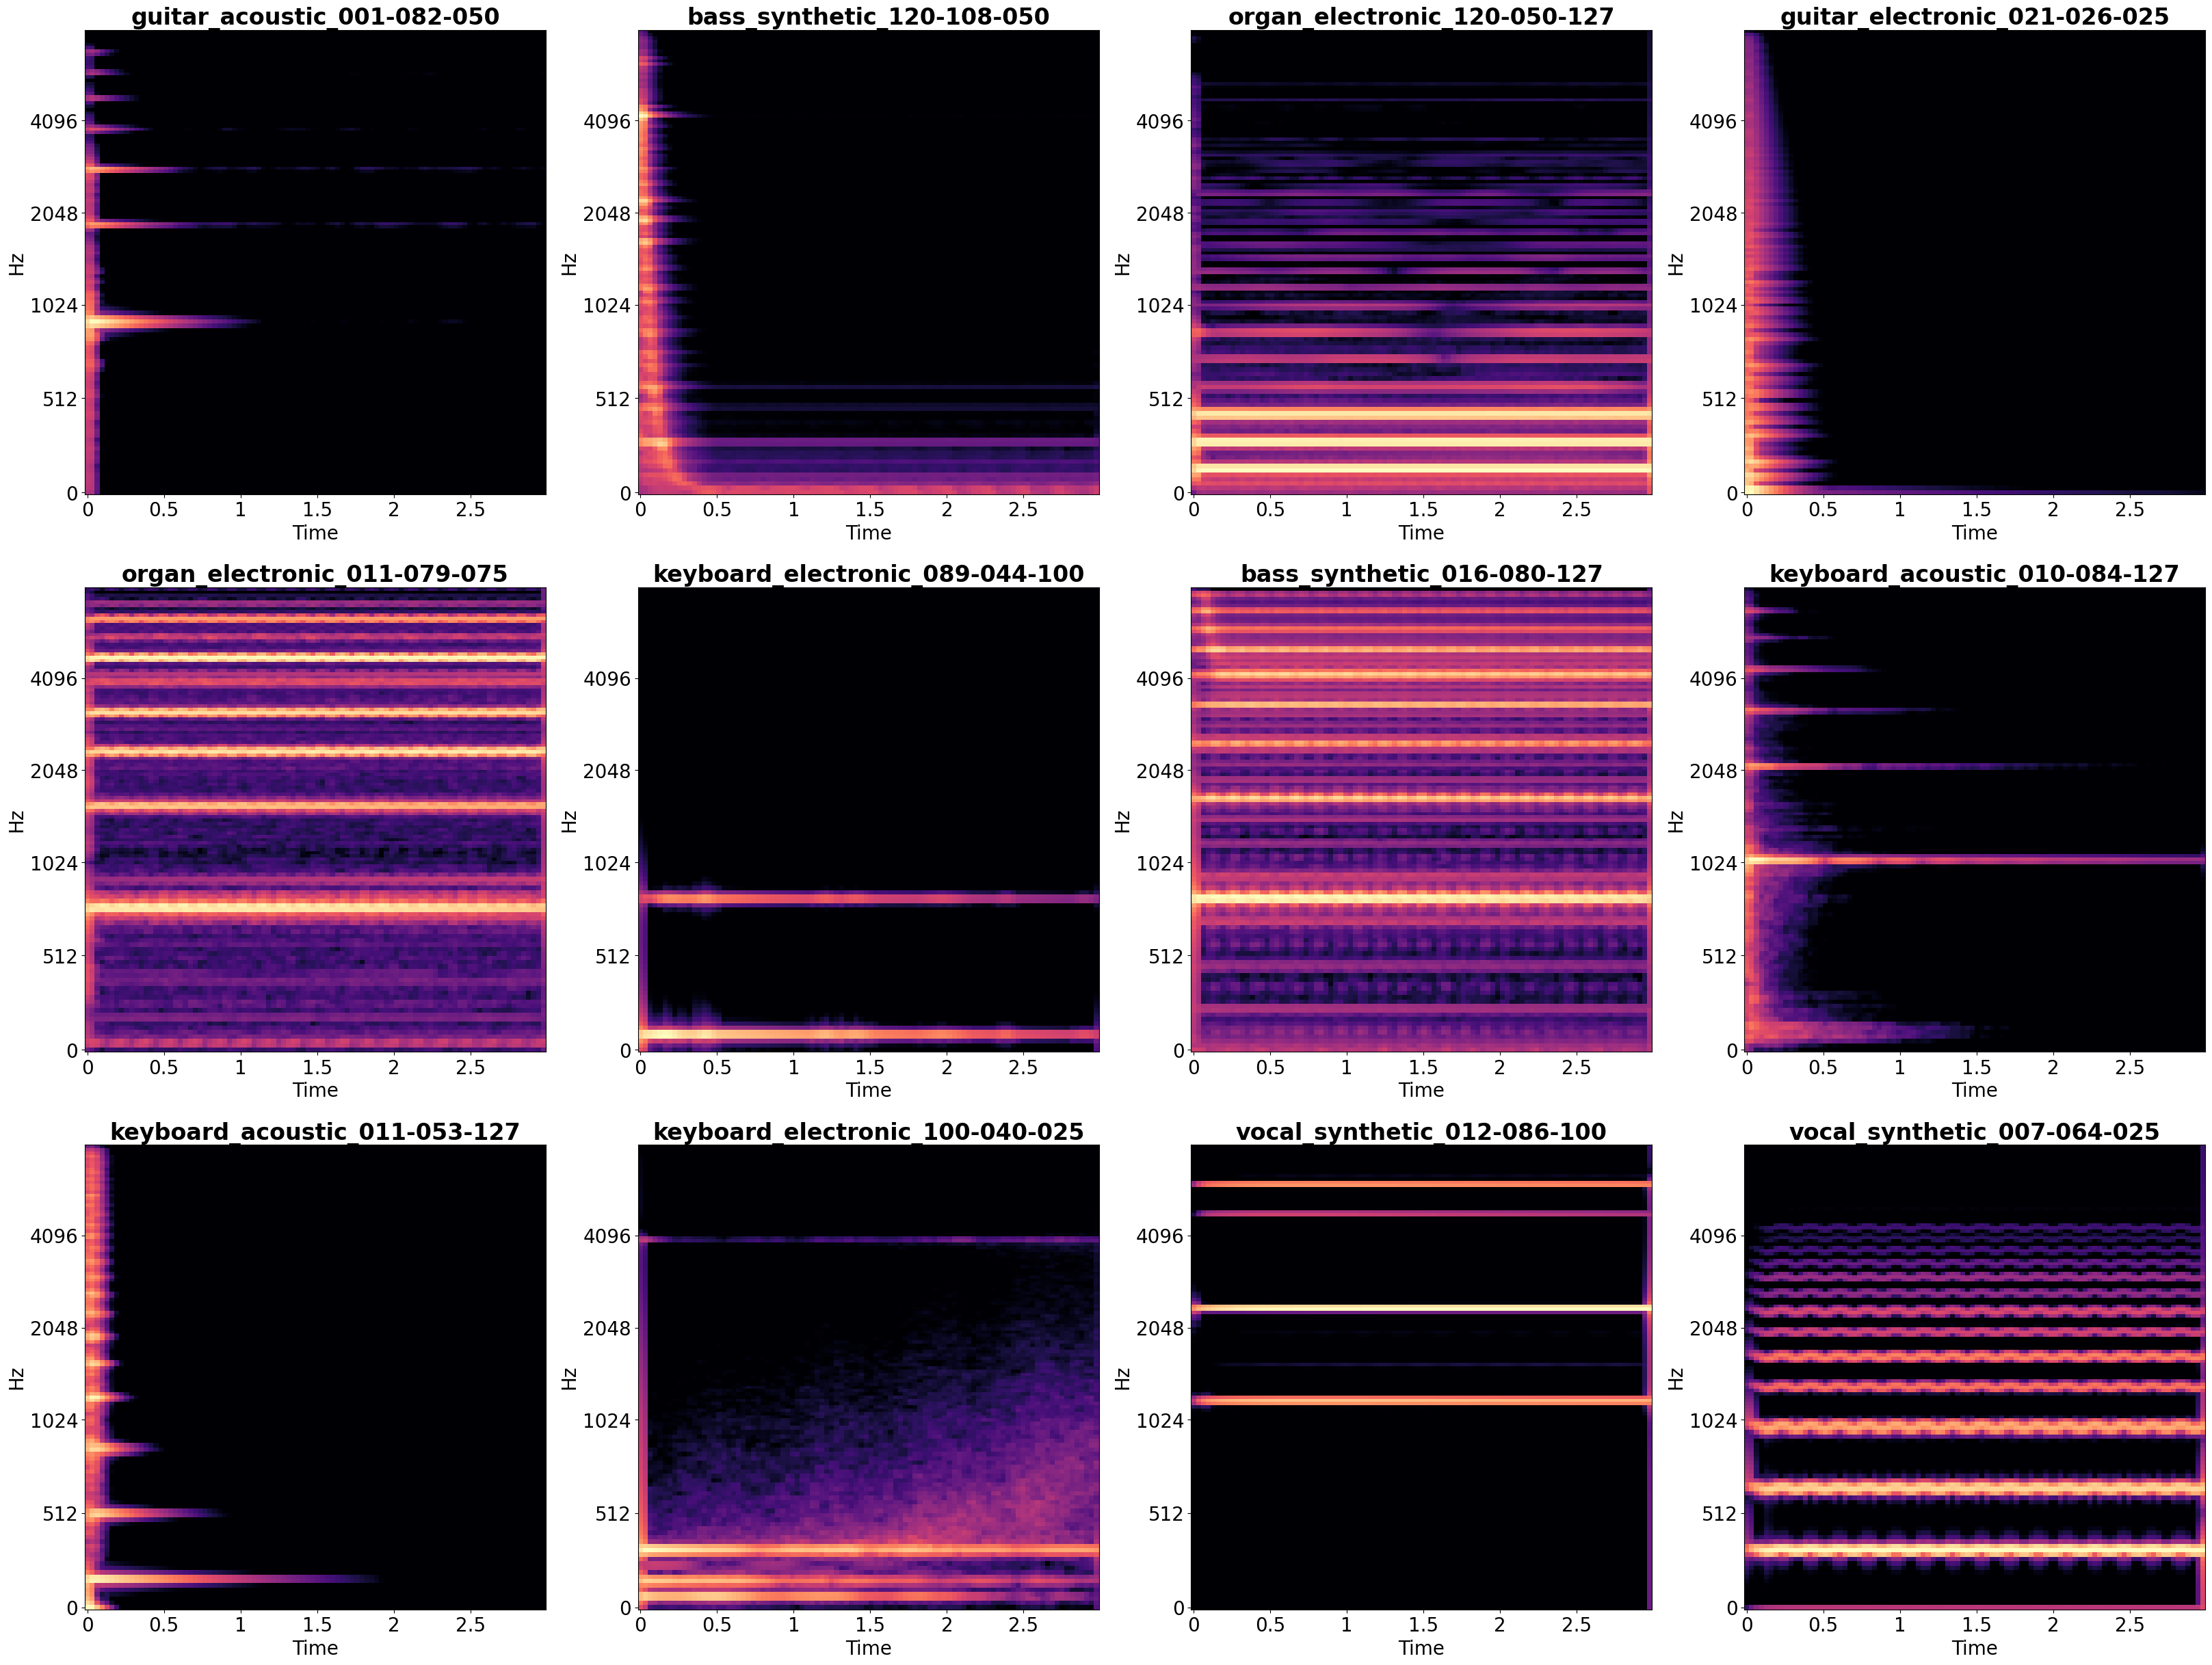

In [32]:
fig, axs = plt.subplots(3, 4, figsize=(40, 30))
for i in range(12):
    ax = axs.flatten()[i]
    m, l = mels.__getitem__(i)
    librosa.display.specshow(librosa.power_to_db(m, ref=np.max),
                         y_axis='mel', x_axis='time', sr=mels.sampling_rate, hop_length=512, ax=ax)
    ax.set_title(mels.fnames[i], fontdict={'fontsize':'large', 'weight':'bold'})


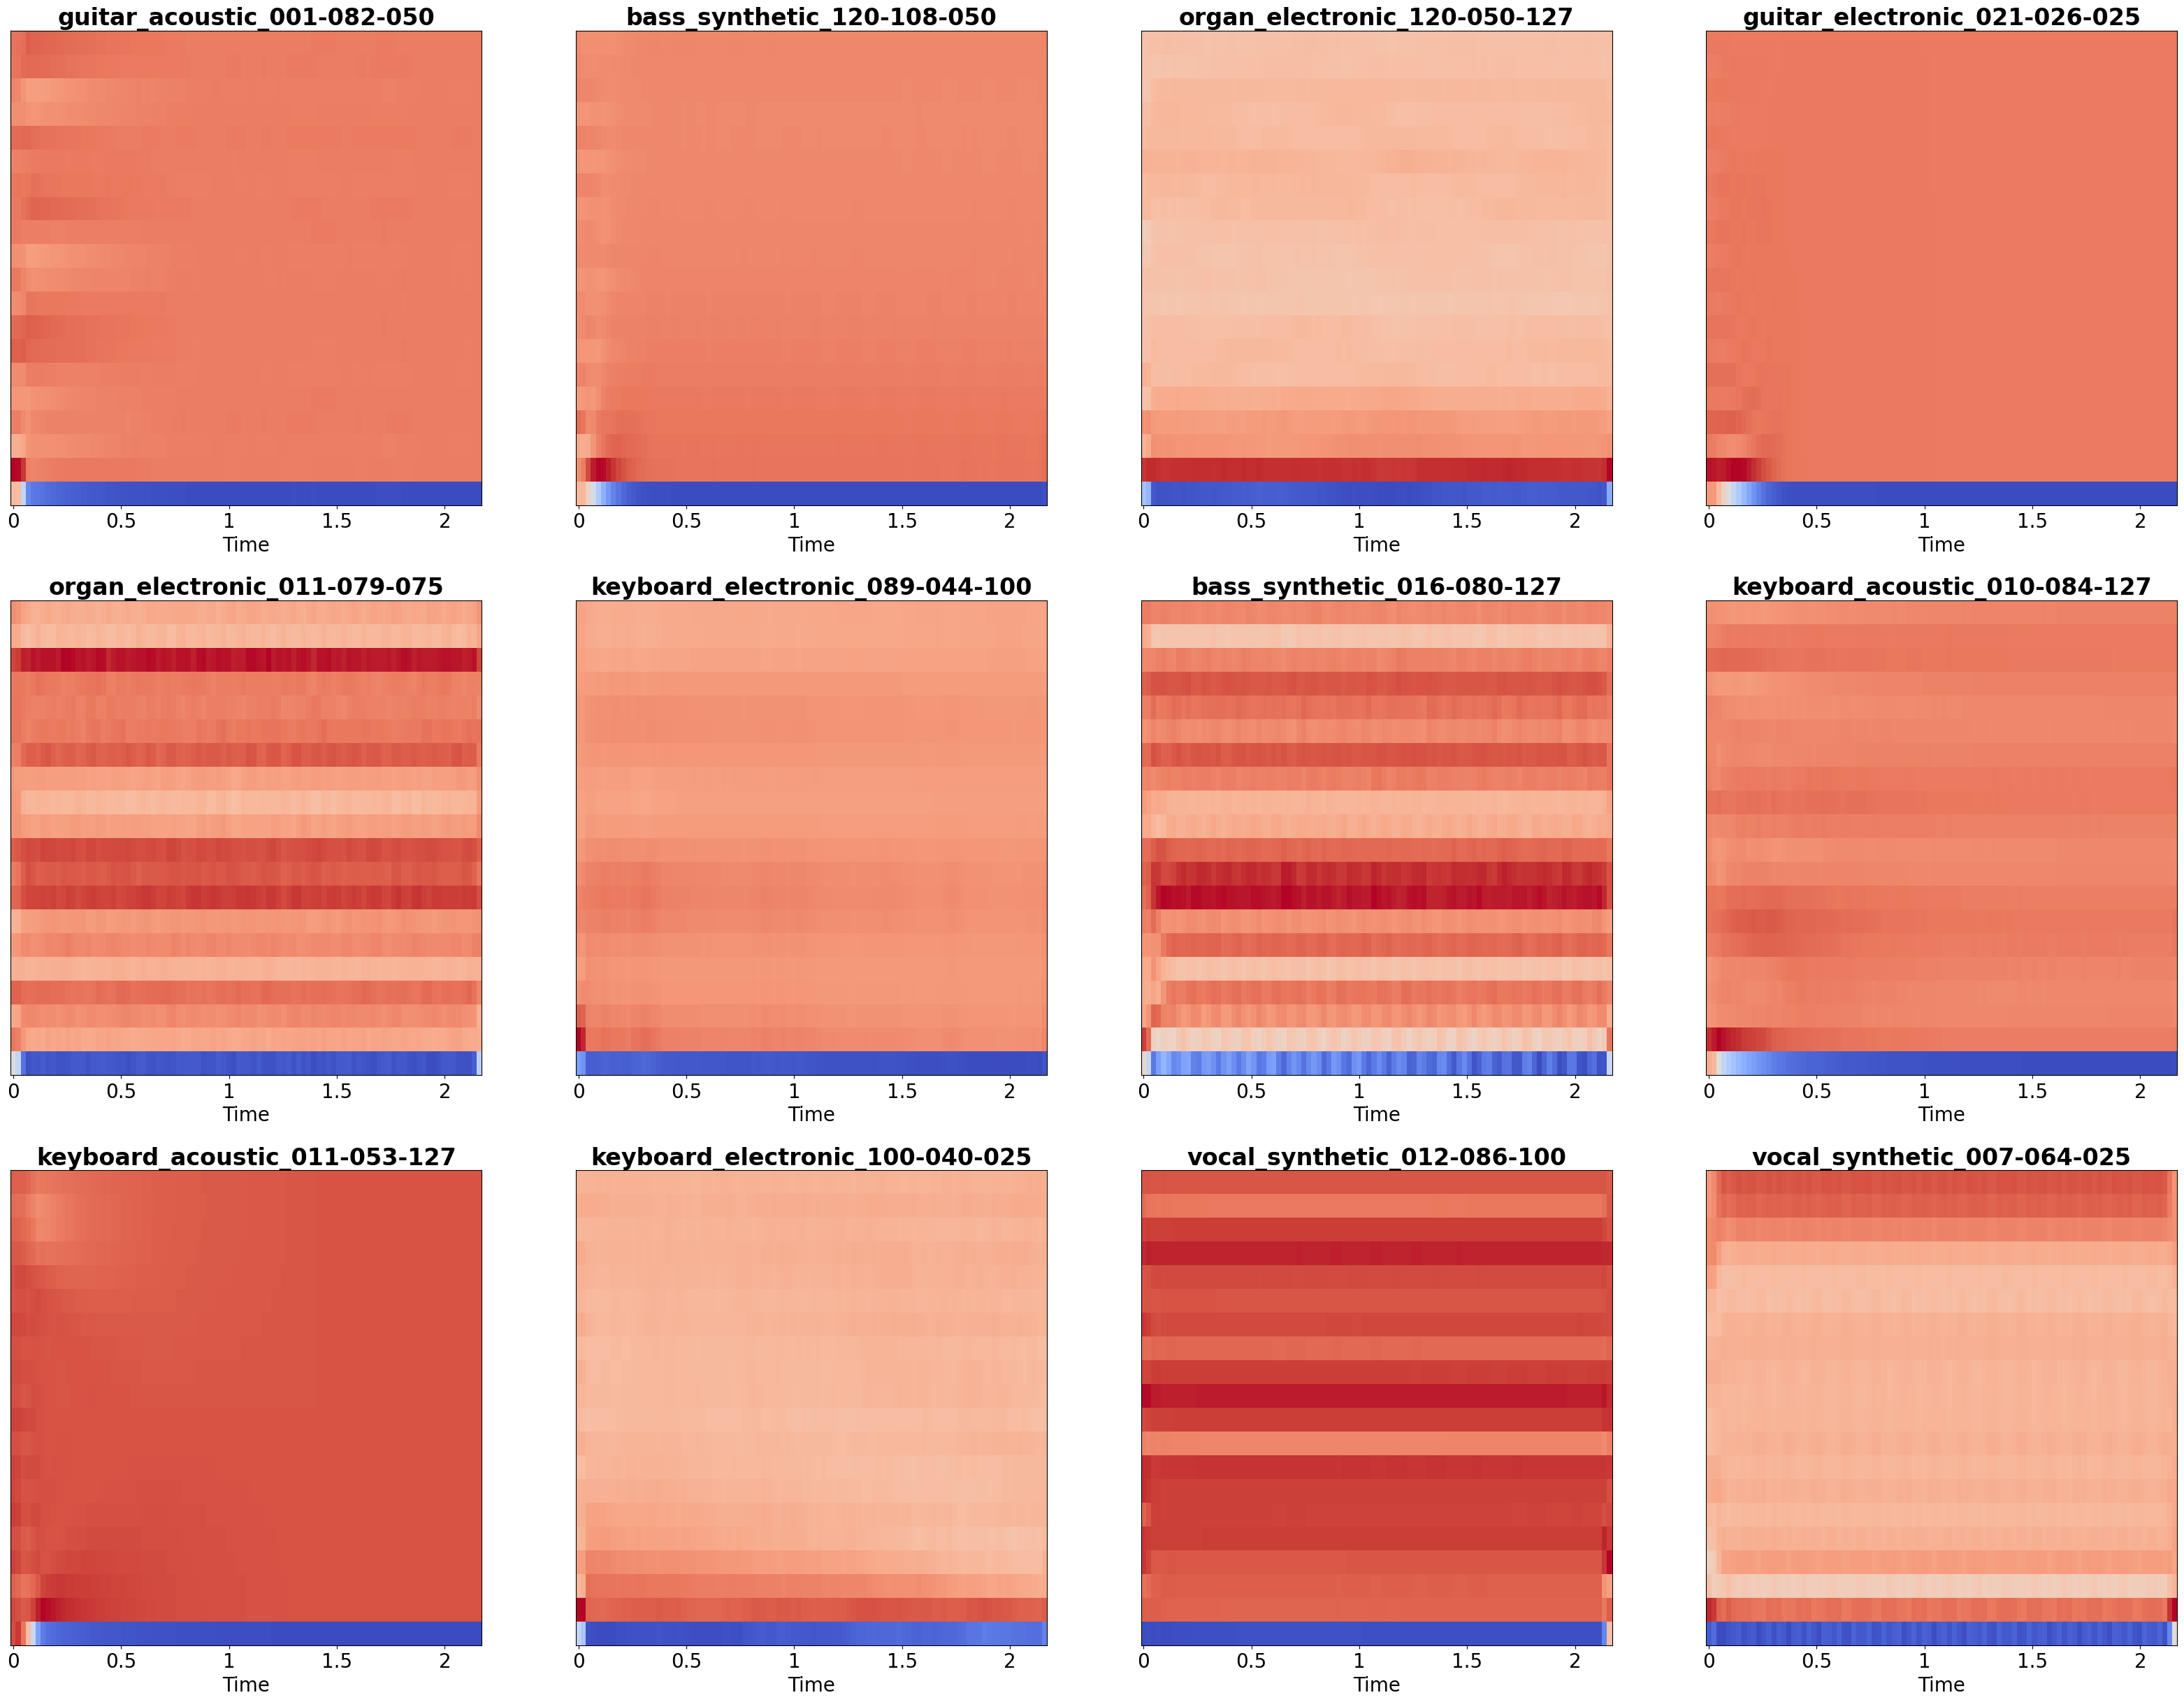

In [44]:
fig, axs = plt.subplots(3, 4, figsize=(40, 30))
for i in range(12):
    ax = axs.flatten()[i]
    a, l = audios.__getitem__(i)
    mfccs = librosa.feature.mfcc(y=np.array(a), sr=audios.sampling_rate)
    librosa.display.specshow(mfccs, x_axis='time', ax=ax)
    ax.set_title('MFCC')
    ax.set_xlabel('Time')
    ax.set_title(mels.fnames[i], fontdict={'fontsize':'large', 'weight':'bold'})
